# **Autokodery**

**Autokoder** składa się z dwóch sieci: **kodera** i **dekodera**. Koder przetwarza dane treningowe w pewną ich reprezentację (*code* na rysunku), najczęściej o mniejszej liczbie wymiarów. Dekoder uczy się odtwarzać oryginalne treści na podstawie ich reprezentacji z możliwie małym błędem. W języku matematyki powiemy, że dążymy, by:
<center>$x \approx D(E(x))$</center>
gdy x to input, a D i E odpowiadają przekształceniu dekodera i kodera.

# Możliwości Modelu

## Analiza PCA

Jeżeli autokoder korzysta wyłącznie z liniowych funkcji aktywacji, a funkcją kosztu jest błąd średniokwadratowy (MSE), to okazuje się, że będzie on przeprowadzał analizę PCA (za: Aurélien Géron, *Hands-On Machine Learning...*).

Przykład dla Julia's parametric heart surface equation:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

2024-01-22 19:52:52.796423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


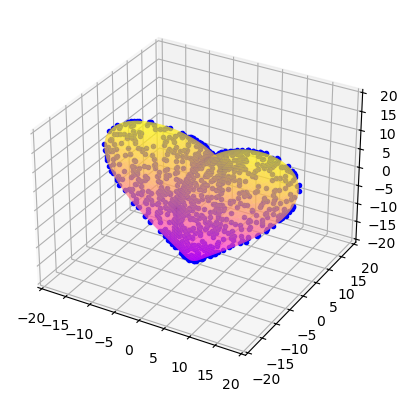

In [4]:
%matplotlib inline

tf.random.set_seed(42)

u, v = np.meshgrid(np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100))

xx = np.sin(v) * (15 * np.sin(u) - 4 * np.sin(3 * u))
yy = 8 * np.cos(v)
zz = np.sin(v) * (15 * np.cos(u) - 5 * np.cos(2 * u) - 2 * np.cos(3 * u) - np.cos(2 * u))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(xx, yy, zz, cmap="spring", alpha=0.5)

points = np.random.choice(10000, size=1000, replace=False)

x = xx.reshape(-1, 1)[points]
y = yy.reshape(-1, 1)[points]
z = zz.reshape(-1, 1)[points]

ax.plot(x, y, z, "b.")

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)

plt.show()

In [5]:
tf.random.set_seed(42)

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer="SGD")

In [6]:
X = np.hstack([x, y, z])

autoencoder.fit(X, X, epochs=10, verbose=False)
codings = encoder.predict(X)

32/32 [==============================] - 0s 1ms/step


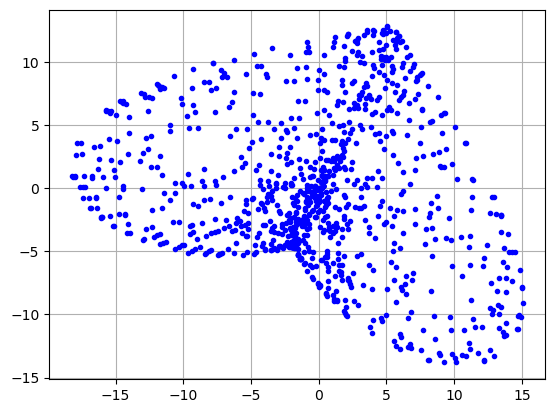

In [7]:
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.grid(True)

plt.show()

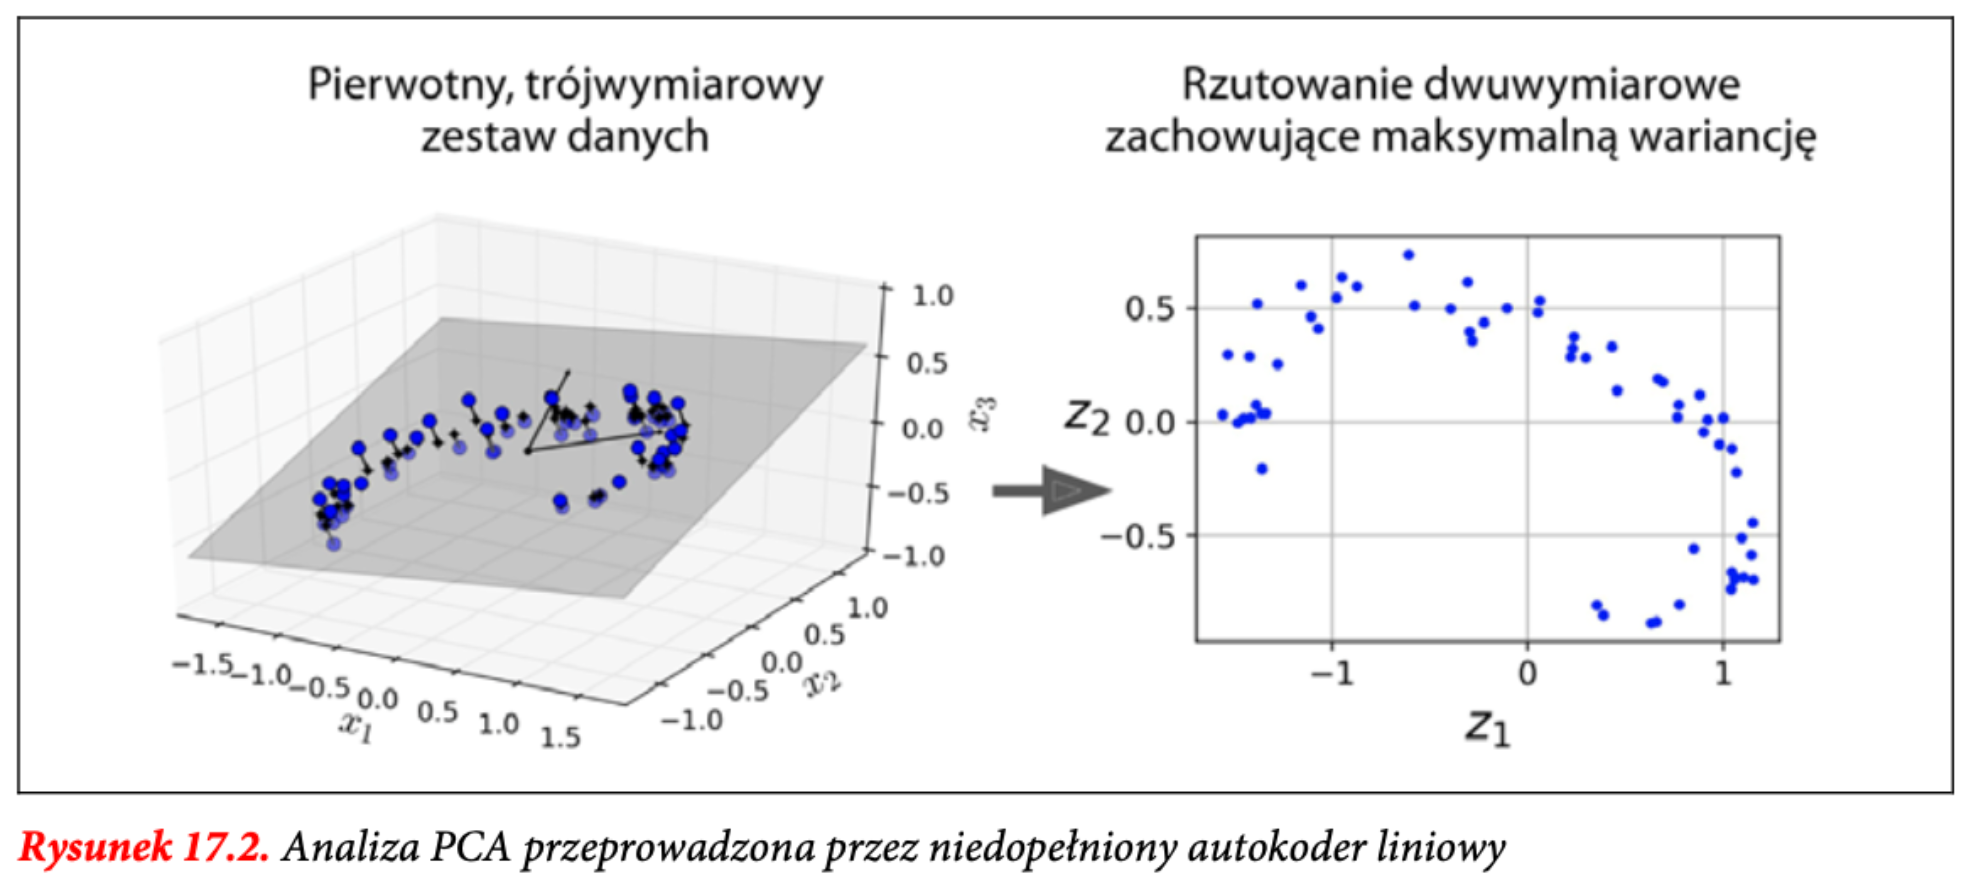

In [8]:
from IPython import display
display.Image("./obrazki/pca.png", width=750)

Ilustracja z książki:

§Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, Aurélien Géron

## Wizualizacja danych

Po wyuczeniu autokodera stosowego [tj. autokodera o przynajmniej dwóch warstwach ukrytych] możemy wykorzystać go do redukowania wymiarowości zestawu danych. W przypadku wizualizacji nie uzyskujemy tak dobrych rezultatów w porównaniu do innych algorytmów redukowania wymiarowości, ale jedną z zalet autokoderów jest możliwość przetwarzania bardzo dużych zestawów danych, zawierających mnóstwo przykładów i cech. Zatem jedną ze strategii jest zredukowanie wymiarowości do rozsądnego poziomu za pomocą autokodera, a następnie przeprowadzenie wizualizacji za pomocą innego algorytmu redukcji wymiarowości.

§Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, Aurélien Géron

Przykład dla zbioru danych MNIST:

In [11]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape, dropout=False):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ]) if not dropout else tf.keras.Sequential([
      layers.Flatten(), tf.keras.layers.Dropout(0.5),
      layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

11490434/11490434 [==============================] - 3s 0us/step


In [14]:
shape = x_test.shape[1:]
latent_dim_64 = 64

autoencoder_64 = Autoencoder(latent_dim_64, shape)

autoencoder_64.compile(optimizer='adam', loss=losses.MeanSquaredError())

number_of_epochs = 10

autoencoder_64.fit(x_train, x_train,
                   epochs=number_of_epochs,
                   shuffle=True,
                   verbose=False)

In [15]:
from sklearn.manifold import TSNE

x_test_compressed = autoencoder_64.encoder.predict(x_test)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
x_test_2D = tsne.fit_transform(x_test_compressed)

313/313 [==============================] - 1s 1ms/step


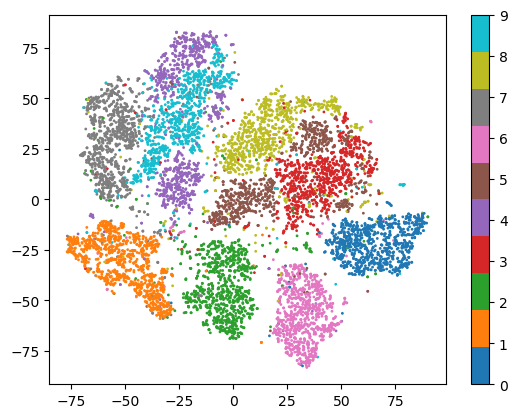

In [16]:
plt.scatter(x_test_2D[:, 0], x_test_2D[:, 1], c=y_test, s=1, cmap="tab10")
plt.colorbar()

plt.show()

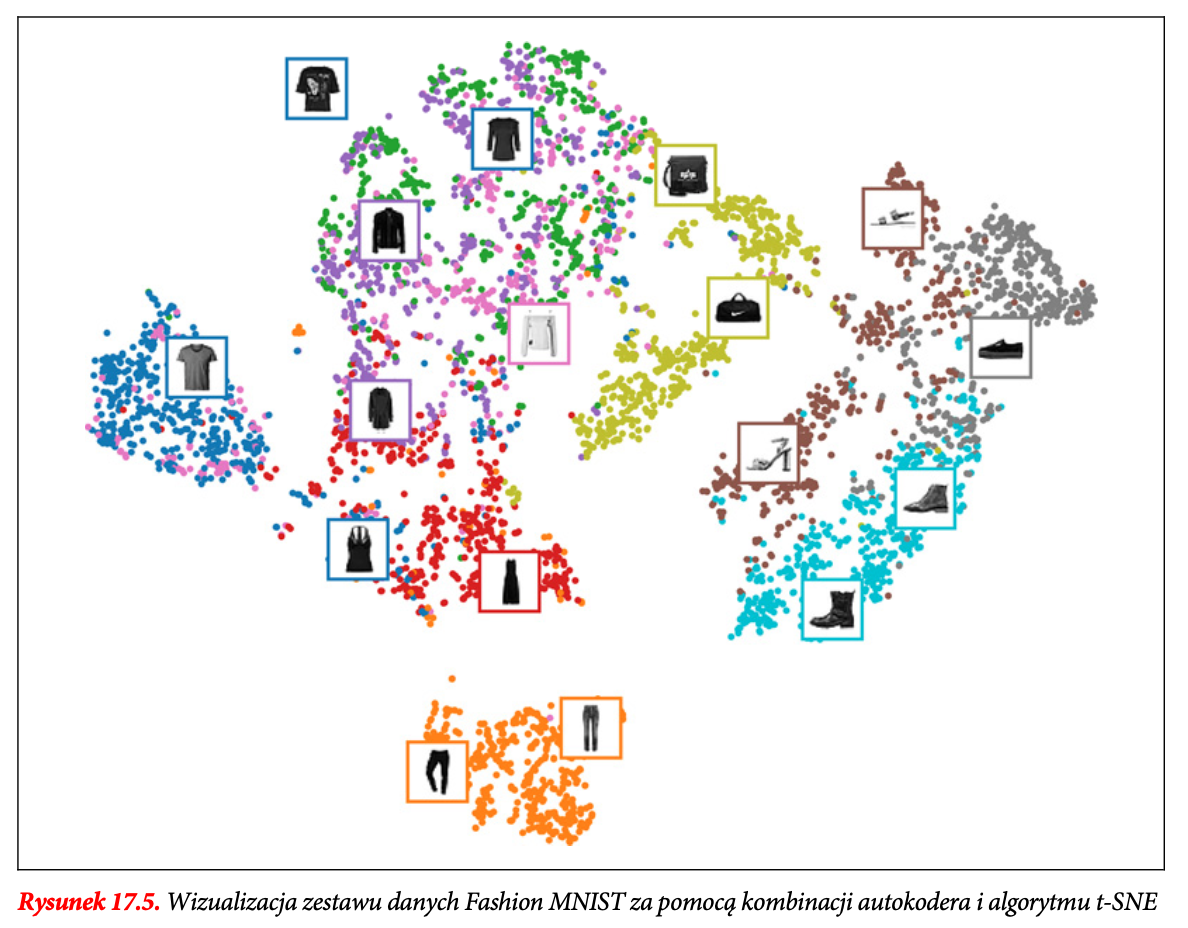

In [17]:
display.Image("./obrazki/visualization.png", width=750)

Ilustracja dla MNIST Fashion:

§Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, Aurélien Géron

## Autokodery Odszumiające

Kolejną metodą zmuszania autokodera do poznawania przydatnych cech jest dodawanie szumu do danych wejściowych i uczenie go odzyskiwania pierwotnych, niezaszumionych informacji. Pierwsze koncepcje wykorzystania autokoderów do odszumiania danych pojawiły się już w latach 80. ubiegłego wieku (m.in. pomysł ten został wspomniany w pracy magisterskiej Yanna LeCuna w 1987 roku). Pascal Vincent i in. udowodnili w publikacji z 2008 roku (https://www.iro.umontreal.ca/~vincentp/Publications/denoising_autoencoders_tr1316.pdf), że autokodery mogą być również używane do wydobywania cech. Z kolei ten sam autor i in. w artykule z 2010 roku (http://jmlr.csail.mit.edu/papers/v11/vincent10a) zaprezentowali odszumiające autokodery stosowe (ang. stacked denoising autoencoders).

Zaszumienie może być standardowym szumem gaussowskim dodawanym do danych wejściowych lub może przybrać postać losowo wyłączanych wejść za pomocą metody porzucania.

§Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, Aurélien Géron

In [18]:
dropout_ae = Autoencoder(64, x_test.shape[1:], dropout=True)

dropout_ae.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [19]:
dropout_ae.fit(x_train, x_train, epochs=10, verbose=False)

In [21]:
def print_decoded_images(output, title):
    n = 10
    plt.figure(figsize=(n, 2))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(output[i])
        plt.title(title)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

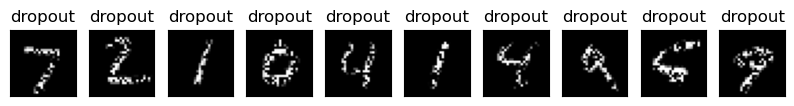

313/313 [==============================] - 1s 3ms/step


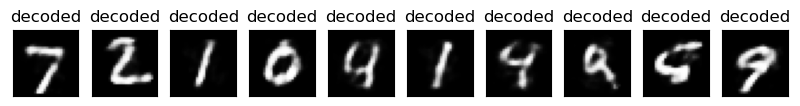

In [22]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
dropout_imgs = dropout(x_test, training=True)
print_decoded_images(dropout_imgs, "dropout")

encoded_imgs = dropout_ae.encoder.predict(dropout_imgs)
decoded_imgs = dropout_ae.decoder.predict(encoded_imgs)
print_decoded_images(decoded_imgs, "decoded")

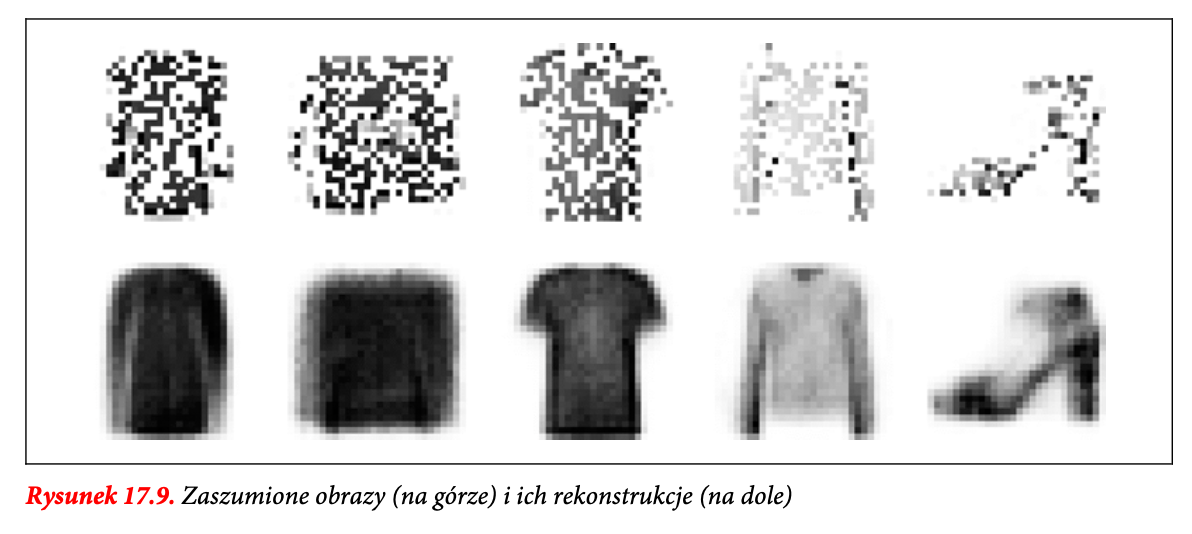

In [23]:
display.Image("./obrazki/denoising.png", width=750)

Obrazek dla MNIST Fashion:

§Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, Aurélien Géron

## Autokodery generatywne

### VAE - Variational Autoencoder

Kolejną istotną kategorię autokoderów zaproponowali **w 2013 roku** (https://arxiv.org/abs/1312.6114) Diederik Kingma i Max Welling; bardzo szybko zyskała ona znaczną popularność. Mowa o **autokoderach wariacyjnych** (ang. *variational autoencoders*).
Różnią się one istotnie od dotychczas omówionych rodzajów autokoderów. Oto główne rozbieżności:
- Są autokoderami **probabilistycznymi** (ang. *probabilistic autoencoders*), co oznacza, że generują częściowo losowe wyniki, nawet po wyuczeniu modelu (w przeciwieństwie do autokoderów odszumiających, w których losowość jest dodawana wyłącznie na wejściu).
- Co ważniejsze, stanowią klasę autokoderów generatywnych, czyli są w stanie tworzyć nowe próbki przypominające dane zawarte w zbiorze uczącym.

Istotnie, jak sama nazwa wskazuje, autokodery wariacyjne przeprowadzają **wariacyjne wnioskowania bayesowskie**, stanowiące skuteczny mechanizm aproksymowanego wnioskowania bayesowskiego.

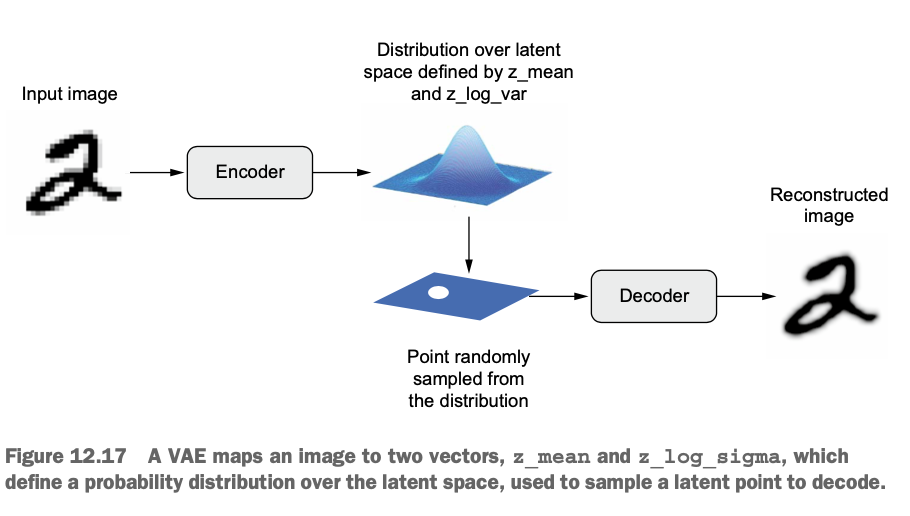

In [24]:
display.Image("./obrazki/vae.png", width=750)

Ilustracja z książki:

§Deep Learning with Python, Francois Chollet

In [25]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [26]:
tf.random.set_seed(42)

shape = x_test.shape[1:]
latent_dim = 64

inputs = tf.keras.layers.Input(shape=shape)
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense((np.prod(shape) + latent_dim) / 2, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(latent_dim)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(latent_dim)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [27]:
decoder_inputs = tf.keras.layers.Input(shape=[latent_dim])
x = tf.keras.layers.Dense((np.prod(shape) + latent_dim) / 2, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(np.prod(shape))(x)
outputs = tf.keras.layers.Reshape(shape)(x)
decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [28]:
_, _, codings = encoder(inputs)
reconstructions = decoder(codings)
VAE = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [29]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
VAE.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [30]:
VAE.compile(loss="mse", optimizer="nadam")
VAE.fit(x_train, x_train, epochs=25, batch_size=128, shuffle=True, verbose=False)


313/313 [==============================] - 1s 3ms/step


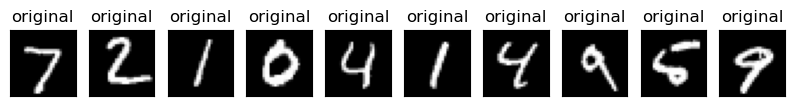

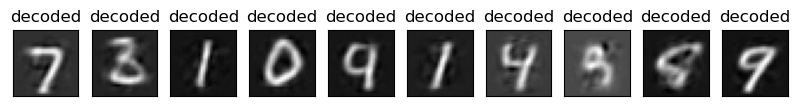

In [31]:
_, _, encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)

print_decoded_images(x_test, "original")
print_decoded_images(decoded, "decoded")

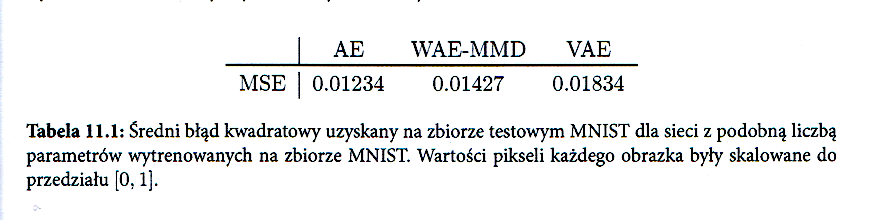

In [32]:
display.Image("./obrazki/gen1.png", width=750)

Tabela porównująca stopień dokładności odtworzenia:

§Głębokie uczenie. Wprowadzenie, Jacek Tabor, Marek Śmieja, Łukasz Struski, Przemysław Spurek, Maciej Wołczyk

In [33]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[10, latent_dim])
images = decoder.predict(codings)

1/1 [==============================] - 0s 50ms/step


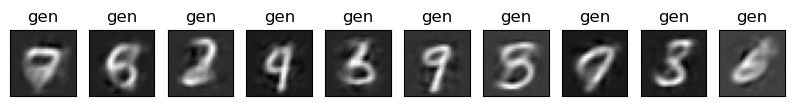

In [34]:
print_decoded_images(images, "gen")

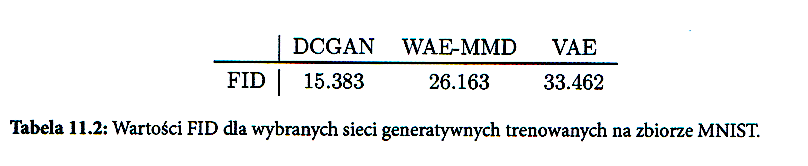

In [35]:
display.Image("./obrazki/gen.png", width=750)

Tabela porównująca stopień poprawności generowania nowych danych:

§Głębokie uczenie. Wprowadzenie, Jacek Tabor, Marek Śmieja, Łukasz Struski, Przemysław Spurek, Maciej Wołczyk

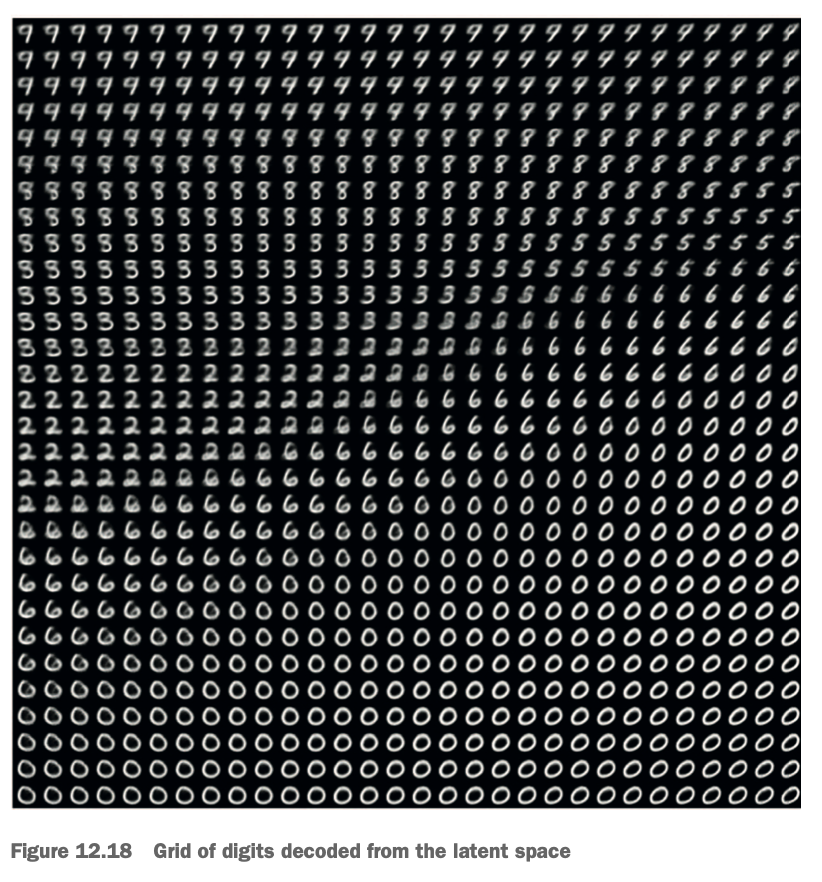

In [36]:
display.Image("./obrazki/vae1.png", width=750)

Ilustracja z książki:

§Deep Learning with Python, Francois Chollet